<div id="teaser" style=' background-position:  right center; background-size: 00px; background-repeat: no-repeat; 
    padding-top: 20px;
    padding-right: 10px;
    padding-bottom: 170px;
    padding-left: 10px;
    border-bottom: 14px double #333;
    border-top: 14px double #333;' > 

   <div style="text-align:center">
   <b><font size="6.4">Finding a tolerance factor to predict perovskite stability with SISSO </font></b>    
  </div>
    
<p>
 created by:
 Lucas Foppa<sup>1</sup>, 
 Thomas Purcell<sup>1</sup>,
 Luigi Sbailò <sup> 1</sup>,
 Christopher Bartel <sup> 2</sup>,
 and Luca M. Ghiringhelli<sup>1</sup> <br><br>
   
<sup>1</sup> Fritz Haber Institute of the Max Planck Society, Berlin, Germany <br>
<sup>2</sup> UC Berkeley, CA, USA <br>
<span class="nomad--last-updated" data-version="v1.0.0">[Last updated: June 24, 2020]</span>
  
<div> 
<img  style="float: left;" src="FHI_logo.png" width="400"> 
<img  style="float: right;" src="NOMAD_logo.jpg" width="200">
</div>
</div>


This tutorial shows how tolerance factors for perovskite stability can be derived from data with the sure independece screening and sparsifying operator (SISSO) descriptor-identification approach.

The SISSO method is described in detail in:

<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
R. Ouyang, S. Curtarolo, E. Ahmetcik, M. Scheffler, L. M. Ghiringhelli: <span style="font-style: italic;">SISSO: a compressed-sensing method for identifying the best low-dimensional descriptor in an immensity of offered candidates</span>, Phys. Rev. Materials  2, 083802 (2018) <a href="https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083802" target="_blank">[PDF]</a> .
</div>

This tutorial is based on the following publication:

<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
C. Bartel, C. Sutton, B. R. Goldsmith, R. Ouyang, C. B. Musgrave, Luca M. Ghiringhelli, M. Scheffler: <span style="font-style: italic;">New tolerance factor to predict the stabilityof perovskite oxides and halides</span>, Sci. Adv.  5, eaav0693 (2019) <a href="https://advances.sciencemag.org/content/advances/5/2/eaav0693.full.pdf" target="_blank">[PDF]</a> .
</div>

# Perovskites and the Goldschmidt tolerance factor

Perovskites are a class of materials having the basic formula $ABX_3$ and displaying a common structure in which a smaller metal cation $B$ (e.g. a transition metal) resides in corner-sharing octahedra of $X$ anions (e.g. $O^2-$, $Cl^-$, $Br^-$) and a larger A metal cation (e.g. alkali, alkaline earth or lanthanide) has a 12-fold coordination with the $X$ anions. This class of compounds has a remarkable variety of electronic, magnetic, optical, mechanical and transport properties, which is derived from the possibility of tuning the materials propertites by the composition. In fact, ca. 90% of the metallic natural elements of the periodic table can be stabilized in a perovskite structure. Therefore, perovskites are versatile materials suitable for a number of applications including photovoltaics, thermoelectrics and catalysis. 

The first step to design new perovskites is to assess their stability. For this purpose, the Goldschmidt tolerance factor, $t$, has been extensively used to predict the stability of a material in the perovskite structure based on the (Shannon) ionic radii,$r_i$, of each ion on the chemical formula $(A,B,X)$: 

$$ t=\frac{r_A+r_X}{\sqrt2(r_B+r_X)} $$

$t$ measures how much the $A$-site cation fits into the corner-sharing octahedral network in a cubic crystal structure. It indicates the compatibilty of a given set of ions with the ideal, cubic perovskite structure ($t\approx1$). Distortions from the cubic structure arise from size mismatch between cations and anions, which results in perovskite structures other than cubic (e.g. orthorhombic, rhombohedral). However, when these distortions are too large, the perovskite structure may be unstable and non-perovskites structures are formed.

The accuracy of the Goldschmidt factor is, however, often insufficient to screen for new potential materials and several modification have been proposed to overcome this issue. In this tutorial, we show how data can be used to derive tolerance factors for perovskite stability. 

# The SISSO method for descriptor identifcation

A crucial step in data-driven materials science is the identification of descriptors, functions of parameters characterizing the phenomena governing a certain property. Descriptors allow distinguishing materials and, crucially, should be obtained (measured or calculated) more easily than the property itself, so that they can be evaluated for large sets of still unknown materials to search for new ones.

The sure independence screening and sparsifying operator (SISSO) method combines a symbolic-regression-based feature construction with compressed sensing for the identification of the best low-dimensional descriptors based on data. Within SISSO feature construction, an initial set of input features (the primary features) offered by the user are systematically combined by the application of mathematical operators (e.g. addition, multiplication, exponential, square root), generating a large space of candidate features. The candidate features are then ranked according to their fit to the target property (number of materials in the overlap of convex-hull regions, for the case of classification problems) and the top-ranked features are further used for descriptor selection.   

For futher details on compressed sensing methods (including SISSO) for descriptor identification, a dedicated notebook is available in the NOMAD toolkit.


# Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import math
import seaborn as sns
import warnings
import itertools

from sisso.feature_creation.feature_space import FeatureSpace
from PredictPerovskites import PredictABX3, PredictAABBXX6

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.calibration import CalibratedClassifierCV  
warnings.filterwarnings('ignore')

# Get the data
The data consists of a list of 576 $ABX_3$ solids experimentally-characterized at ambient conditions, classified as stable or unstable at the perovskite structure, together with the following features:
<div >

<ul>
      <li>$r_A, r_B, r_X$: Shannon ionic radii of each ion, with $r_A>r_B$ </li>
      <li>$n_A, n_B, n_X$: oxidation satates of each ion </li>
      <li>$\frac{r_A}{r_B}, \frac{r_A}{r_X}, \frac{r_B}{r_x}$: ionic radii ratios </li>
       <li>$Z_A, Z_B, Z_X$: nuclear charges </li>
      <li>$r_{s,A}, r_{s,B}, r_{s,X}$: calculated radius where the radial distribution of the $s$ orbital has its maximum </li>
      <li>$r_{p,A}, r_{p,B}, r_{p,X}$: calculated radius where the radial distribution of the $p$ orbital has its maximum</li>
      <li>$HOMO_A, HOMO_B, HOMO_X$: calculated energy of the highest occupied atomic orbital</li>
      <li>$LUMO_A, LUMO_B, LUMO_X$: calculated energy of the lowest unoccupied atomic orbital</li>
      <li>$EA_A, EA_B, EA_X$: calculated electron affinity</li>
      <li>$IP_A, IP_B, IP_X$: calculated ionization potential</li>
</div> 
    
The calculated features were obtained with DFT-PBE using the FHI-aims all-electron full-potential code and correspond to properties of isolated atoms. 


In [2]:
#load data
df = pd.read_csv("data_perovskite.csv", index_col=0)

#show data
df

exp_label    rA    rB    rX  nA  nB  nX  rA_rB_ratio  rA_rX_ratio  \
material                                                                      
AgBrO3           -1  1.28  0.31  1.40   1   5  -2      4.12903     0.914286   
AgCdBr3          -1  1.28  0.95  1.96   1   2  -1      1.34737     0.653061   
PbAgBr3          -1  1.49  1.15  1.96   2   1  -1      1.29565     0.760204   
AgCaCl3          -1  1.28  1.00  1.81   1   2  -1      1.28000     0.707182   
AgClO3           -1  1.28  0.12  1.40   1   5  -2     10.66670     0.914286   
...             ...   ...   ...   ...  ..  ..  ..          ...          ...   
RbUO3             1  1.72  0.76  1.40   1   5  -2      2.26316     1.228570   
SmTiO3            1  1.24  0.67  1.40   3   3  -2      1.85075     0.885714   
SrTeO3           -1  1.44  0.97  1.40   2   4  -2      1.48454     1.028570   
SrTiO3            1  1.44  0.60  1.40   2   4  -2      2.40000     1.028570   
YTmO3            -1  1.08  0.88  1.40   3   3  -2      1.22727     0.771429   

          rB_rX_ratio  ...    LUMO_B      EA_B       IP_B    rS_X    rP_X  \
material               ...                                                  
AgBrO3       0.221429  ...  0.055110 -3.678151  12.554312  0.4608  0.4333   
AgCdBr3      0.484694  ... -1.157118  0.948262   9.271930  0.7514  0.8834   
PbAgBr3      0.586735  ... -0.246293 -1.475587   7.755963  0.7514  0.8834   
AgCaCl3      0.552486  ... -1.945848  0.149995   6.309260  0.6785  0.7567   
AgClO3       0.085714  ...  0.019724 -3.935230  13.876021  0.4608  0.4333   
...               ...  ...       ...       ...        ...     ...     ...   
RbUO3        0.542857  ... -1.995273  0.546862   5.590258  0.4608  0.4333   
SmTiO3       0.478571  ... -4.219539 -0.313899   7.119307  0.4608  0.4333   
SrTeO3       0.692857  ...  0.193946 -2.575489   9.729526  0.4608  0.4333   
SrTiO3       0.428571  ... -4.219539 -0.313899   7.119307  0.4608  0.4333   
YTmO3        0.628571  ... -1.072406  0.522244   6.424662  0.4608  0.4333   

          Z_X    HOMO_X    LUMO_X      EA_X       IP_X  
material                                                
AgBrO3      8 -9.030485 -0.068724 -3.078804  16.431366  
AgCdBr3    35 -7.858439  0.055110 -3.678151  12.554312  
PbAgBr3    35 -7.858439  0.055110 -3.678151  12.554312  
AgCaCl3    17 -8.594666  0.019724 -3.935230  13.876021  
AgClO3      8 -9.030485 -0.068724 -3.078804  16.431366  
...       ...       ...       ...       ...        ...  
RbUO3       8 -9.030485 -0.068724 -3.078804  16.431366  
SmTiO3      8 -9.030485 -0.068724 -3.078804  16.431366  
SrTeO3      8 -9.030485 -0.068724 -3.078804  16.431366  
SrTiO3      8 -9.030485 -0.068724 -3.078804  16.431366  
YTmO3       8 -9.030485 -0.068724 -3.078804  16.431366  

[576 rows x 31 columns]

In [3]:
#count the number of material in each class in the whole dataset
print('In the whole dataset, %s compositions are unstable and %s are stable.' % (df['exp_label'].value_counts().values[0], df['exp_label'].value_counts().values[1]))

In the whole dataset, 313 compositions are unstable and 263 are stable.


In [4]:
#split the data in 80% training and 20% testing
train,test=train_test_split(df,test_size=0.2)

In [5]:
#count the number of material in each class in the training/test sets
print('In the training set, %s compositions are unstable and %s are stable.' % (train['exp_label'].value_counts().values[0], train['exp_label'].value_counts().values[1]))
print('In the test set, %s compositions are unstable and %s are stable.' % (test['exp_label'].value_counts().values[0], test['exp_label'].value_counts().values[1]))

In the training set, 237 compositions are unstable and 223 are stable.
In the test set, 76 compositions are unstable and 40 are stable.


In [6]:
#sort the training data by the labels (stable/unstable)
train.sort_values(by=['exp_label'],inplace=True)

# Generate the candidate features space from the primary features and operators
The two ingredients to create the feature space with SISSO are the features to be used (i.e. the primary features) and the set of mathematical operators to be applied. Another input from the user is the number of times the operators are applied, the so-called rung (max_phi).  

In [10]:
#add the primary features units to the training set
train_units=train.rename(columns={'rA':'rA (AA)', 'rB':'rB (AA)', 'rX':'rX (AA)',
                      'nA':'nA (Unitless)', 'nB':'nB (Unitless)', 'nX':'nX (Unitless)',
                      'rA_rB_ratio':'rA_rB_ratio (Unitless)', 'rA_rX_ratio':'rA_rX_ratio (Unitless)', 'rB_rX_ratio':'rB_rX_ratio (Unitless)',
                      'rS_A':'rS_A (AA)', 'rP_A':'rP_A (AA)',
                      'Z_A':'Z_A (elem_charge)',
                      'HOMO_A':'HOMO_A (eV)', 'LUMO_A':'LUMO_A (eV)',
                      'EA_A':'EA_A (eV)', 'IP_A':'IP_A (eV)',
                      'rS_B':'rS_B (AA)', 'rP_B':'rP_B (AA)',
                      'Z_B':'Z_B (elem_charge)',
                      'HOMO_B':'HOMO_B (eV)', 'LUMO_B':'LUMO_B (eV)',
                      'EA_B':'EA_B (eV)', 'IP_B':'IP_B (eV)',
                      'rS_X':'rS_X (AA)', 'rP_X':'rP_X (AA)',
                      'Z_X':'Z_X (elem_charge)',
                      'HOMO_X':'HOMO_X (eV)','LUMO_X':'LUMO_X (eV)',
                      'EA_X':'EA_X (eV)', 'IP_X':'IP_X (eV)',
                     })


In [103]:
#define list of primary features - user has to choose
cols = [
    'rA (AA)',
    'rB (AA)',
    'rX (AA)',
    'nA (Unitless)',
#    'nB (Unitless)',
#    'nX(Unitless)',
    'rA_rB_ratio (Unitless)',
    'rA_rX_ratio (Unitless)',
    'rB_rX_ratio (Unitless)',
#    'rS_A (AA)',
#    'rP_A (AA)',
#    'Z_A (elem_charge)',
#    'HOMO_A (eV)',
#    'LUMO_A (eV)',
#    'EA_A (eV)',
#    'IP_A (eV)',
#    'rS_B (AA)',
#    'rP_B (AA)',
#    'Z_B (elem_charge)',
#    'HOMO_B (eV)',
#    'LUMO_B (eV)',
#    'EA_B (eV)',
#    'IP_B (eV)',
#    'rS_X (AA)',
#    'rP_X (AA)',
#    'Z_X (elem_charge)',
#    'HOMO_X (eV)',
#    'LUMO_X (eV)',
#    'EA_X (eV)',
#    'IP_X  (eV)'
]

In [104]:
#define list of operators - user has to choose
ops = [
#    "add",
    "sub",
#    "abs_diff",
    "mult",
    "div",
#    "exp",
#    "neg_exp",
#    "inv",
#    "sq",
#    "cb",
#    "sixth_power",
#    "sqrt",
#    "cbrt",
    "log",
#    "abs",
#    "sin",
#    "cos",
]

In [105]:
#feature space creation - user has to choose rung and sis
fs = FeatureSpace.from_df(
    train_units,
    "exp_label",
    ops,
    cols,
    max_phi=2,  # rung
    n_sis_select=500,
    parameterize=False,
    fix_c_0=False,
    learn_type="classification",
)

In [106]:
#visualize the feature space created
fs.all_df

rA (AA^1.0)  rB (AA^1.0)  rX (AA^1.0)  nA ()  rA_rB_ratio ()  \
material                                                                 
FeGaO3           0.78         0.62         1.40    3.0         1.25806   
TlBeCl3          1.70         0.45         1.81    1.0         3.77778   
BaTeO3           1.61         0.97         1.40    2.0         1.65979   
AgCdBr3          1.28         0.95         1.96    1.0         1.34737   
AgVO3            1.28         0.54         1.40    1.0         2.37037   
...               ...          ...          ...    ...             ...   
EuCrO3           1.12         0.62         1.40    3.0         1.80645   
YAlO3            1.08         0.54         1.40    3.0         2.00000   
LuFeO3           1.03         0.64         1.40    3.0         1.60938   
YGaO3            1.08         0.62         1.40    3.0         1.74194   
TlMnCl3          1.70         0.83         1.81    1.0         2.04819   

          rA_rX_ratio ()  rB_rX_ratio ()  rA - rB (AA^1.0)  rA*rB (AA^2.0)  \
material                                                                     
FeGaO3          0.557143        0.442857             -0.16          0.4836   
TlBeCl3         0.939227        0.248619             -1.25          0.7650   
BaTeO3          1.150000        0.692857             -0.64          1.5617   
AgCdBr3         0.653061        0.484694             -0.33          1.2160   
AgVO3           0.914286        0.385714             -0.74          0.6912   
...                  ...             ...               ...             ...   
EuCrO3          0.800000        0.442857             -0.50          0.6944   
YAlO3           0.771429        0.385714             -0.54          0.5832   
LuFeO3          0.735714        0.457143             -0.39          0.6592   
YGaO3           0.771429        0.442857             -0.46          0.6696   
TlMnCl3         0.939227        0.458564             -0.87          1.4110   

          rA - rX (AA^1.0)  ...  1.0*rB_rX_ratio/(rA_rX_ratio*rX) (AA^-1.0)  \
material                    ...                                               
FeGaO3                0.62  ...                                    1.112820   
TlBeCl3               0.11  ...                                    0.479118   
BaTeO3               -0.21  ...                                    0.843478   
AgCdBr3               0.68  ...                                    1.454688   
AgVO3                 0.12  ...                                    0.590624   
...                    ...  ...                                         ...   
EuCrO3                0.28  ...                                    0.775000   
YAlO3                 0.32  ...                                    0.699999   
LuFeO3                0.37  ...                                    0.869904   
YGaO3                 0.32  ...                                    0.803703   
TlMnCl3               0.11  ...                                    0.883706   

          1.0*rA_rX_ratio*rX/rB_rX_ratio (AA^1.0)  \
material                                            
FeGaO3                                   0.898618   
TlBeCl3                                  2.087169   
BaTeO3                                   1.185567   
AgCdBr3                                  0.687432   
AgVO3                                    1.693123   
...                                           ...   
EuCrO3                                   1.290323   
YAlO3                                    1.428573   
LuFeO3                                   1.149553   
YGaO3                                    1.244241   
TlMnCl3                                  1.131598   

          1.0*rB_rX_ratio/(nA*rA_rX_ratio) ()  \
material                                        
FeGaO3                               2.384614   
TlBeCl3                              0.264706   
BaTeO3                               1.204969   
AgCdBr3                              0.742188   
AgVO3               

In [107]:
#count the number of features created
print('From %s primary features and %s operators, SISSO generated a feature space containing %s candidate features.' % (len(cols),len(ops),fs.all_df.shape[1]))

From 7 primary features and 4 operators, SISSO generated a feature space containing 12070 candidate features.


# Select the best candidate features and classification thresholds
Next, the generated candidate features are selected in two steps. In a first step, they are ranked according to the number of materials $N$ that fall in overlapping regions of stable and unstable domains and only the top-ranked features are kept. The domain is defined as the range between the maximum and minimum values of the feature for each of the classes (stable and unstable). The best candidate features are those that present lower $N$. The lenght of the overlap domain, $S$, is used to rank features presenting the same $N$. $N$ and $S$ correspond to equations 2 and 3, respectively, in Phys. Rev. Materials 2, 083802 (2018).

In [108]:
fs.sis()

In [109]:
feature_space=fs.df
feature_space

rA_rB_ratio*(rA_rX_ratio - rB_rX_ratio)/nA ()  \
material                                                  
FeGaO3                                        -0.272529   
TlBeCl3                                       -0.182808   
BaTeO3                                        -0.550844   
AgCdBr3                                       -0.124960   
AgVO3                                         -0.222991   
...                                                 ...   
EuCrO3                                        -0.593113   
YAlO3                                         -0.578573   
LuFeO3                                        -0.519276   
YGaO3                                         -0.565873   
TlMnCl3                                       -0.234677   

          1.0*rA_rB_ratio*(rA_rX_ratio - rB_rX_ratio)/nA ()  \
material                                                      
FeGaO3                                            -3.669332   
TlBeCl3                                           -5.470223   
BaTeO3                                            -1.815395   
AgCdBr3                                           -8.002578   
AgVO3                                             -4.484479   
...                                                     ...   
EuCrO3                                            -1.686019   
YAlO3                                             -1.728392   
LuFeO3                                            -1.925757   
YGaO3                                             -1.767182   
TlMnCl3                                           -4.261177   

          nA*rB_rX_ratio*(rA - rB) (AA^1.0)  \
material                                      
FeGaO3                            -0.212571   
TlBeCl3                           -0.310774   
BaTeO3                            -0.886857   
AgCdBr3                           -0.159949   
AgVO3                             -0.285428   
...                                     ...   
EuCrO3                            -0.664285   
YAlO3                             -0.624857   
LuFeO3                            -0.534857   
YGaO3                             -0.611143   
TlMnCl3                           -0.398951   

          nA*rA_rX_ratio/(1.0*rA_rB_ratio - 1.0*rA_rX_ratio) ()  \
material                                                          
FeGaO3                                            -0.419352       
TlBeCl3                                           -3.022223       
BaTeO3                                            -0.221648       
AgCdBr3                                           -1.063161       
AgVO3                                             -1.592591       
...                                                     ...       
EuCrO3                                            -0.419354       
YAlO3                                             -0.530864       
LuFeO3                                            -0.395836       
YGaO3                                             -0.419356       
TlMnCl3                                           -1.180719       

          1.0*(rA_rB_ratio - rA_rX_ratio)/(nA*rA_rX_ratio) ()  \
material                                                        
FeGaO3                                            -2.384632     
TlBeCl3                                           -0.330882     
BaTeO3                                            -4.511662     
AgCdBr3                                           -0.940591     
AgVO3                                             -0.627907     
...                                                     ...     
EuCrO3                                            -2.384619     
YAlO3                                             -1.883723     
LuFeO3                                            -2.526300     
YGaO3                                             -2.384607     
TlMnCl3                                           -0.846942     

          -nA*rB + rB - rX (AA^1.0)  nA*rA_rX_ratio*rB_rX_ratio ()  \
material              

In a second step, classification trees are used to choose the best candidate feature among those selected by the overlaps (above). For each of the selected candidate features, a classification tree is trained, providing a threshold for the classification and its accuracy. The selected candidate features get ranked based on their accuracy. 

In [110]:
#train classification trees for the selected descriptors

#depth of the classification tree - user has to choose
def rank_tree(labels, feature_space, depth):
    #rank features according to the classification tree accuracy
    score = []
    for i in list(range(0,fs.df.shape[1])):
        x=np.array(feature_space)[:,i]
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(x.reshape(-1,1), labels)
        score.append([feature_space.columns.values[i],clf.score(x.reshape(-1,1),labels)])
    score_sorted=sorted(score,reverse=True,key=lambda x: x[1])
    return score_sorted

labels_train=train["exp_label"].to_numpy()

rank_list=rank_tree(labels_train, feature_space, 1)
pd.DataFrame(rank_list, columns=['feature','tree accuracy'])

feature  tree accuracy
0                     nA*rA_rX_ratio**2*rB_rX_ratio ()       0.839130
1    rA*rA_rB_ratio/(1.0*rA_rX_ratio - 1.0*rB_rX_ra...       0.839130
2    1.0*(rA_rX_ratio - rB_rX_ratio)/(rA*rA_rB_rati...       0.839130
3                     nA*rA_rX_ratio*rB_rX_ratio**2 ()       0.832609
4                    nA*rB_rX_ratio*(rA - rB) (AA^1.0)       0.826087
..                                                 ...            ...
495                 nA*(nA - rB_rX_ratio)/rA (AA^-1.0)       0.576087
496       1.0*nA*rX/(rA_rB_ratio*rA_rX_ratio) (AA^1.0)       0.571739
497                             rA*rB*log(rB) (AA^2.0)       0.569565
498  nA*rA/(1.0*rA_rX_ratio - 1.0*rB_rX_ratio) (AA^...       0.565217
499             1.0*rA_rB_ratio*log(rA_rX_ratio)/nA ()       0.547826

[500 rows x 2 columns]

The top-ranked candidate feature corresponds to the the SISSO-derived tolerance factor. Wel call this descriptor $t_{sisso}$. 

In [113]:
t_sisso_expression=str(rank_list[0][0]).rsplit('(',1)[0]
print('Identified expression for t_sisso: %s' % t_sisso_expression)

Identified expression for t_sisso: nA*rA_rX_ratio**2*rB_rX_ratio 


$t_{sisso}$ can be now evaluated for all the materials, including those in the test set. For comparison, we also evaluate the Goldshimit factor ($t$) and the $\tau$ descriptor found in Sci. Adv. 5, eaav0693 (2019).

In [118]:
train.eval('t_sisso = ' + t_sisso_expression, inplace=True)
train.eval('t = (rA+rX)/(1.41421*(rB+rX))', inplace=True)
train.eval('tau = rX/rB-nA*(nA-rA_rB_ratio/log(rA_rB_ratio))', inplace=True)

test.eval('t_sisso = ' + t_sisso_expression, inplace=True)
test.eval('t = (rA+rX)/(1.41421*(rB+rX))', inplace=True)
test.eval('tau = rX/rB-nA*(nA-rA_rB_ratio/log(rA_rB_ratio))', inplace=True)


# Evalute the descriptor performance

The accuracy of the classification tree for $t_{sisso}$ can be now evaluated for train and test sets. A maximum depth of one is used here. 

Classification tree accuracy (for t_sisso) on the train set: 0.839130.
Classification tree accuracy (for t_sisso) on the test set: 0.801724.


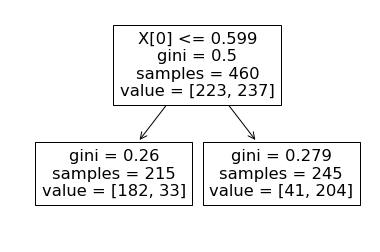

In [125]:
#train classification tree with t_sisso
x_train_t_sisso=train['t_sisso'].to_numpy()
x_test_t_sisso=test['t_sisso'].to_numpy()
labels_test=test['exp_label'].to_numpy()

clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(x_train_t_sisso.reshape(-1,1),labels_train)
labels_pred=clf.predict(x_test_t_sisso.reshape(-1,1))
tree.plot_tree(clf)
print('Classification tree accuracy (for t_sisso) on the train set: %f.' % clf.score(x_train_t_sisso.reshape(-1,1),labels_train))
print('Classification tree accuracy (for t_sisso) on the test set: %f.' % metrics.accuracy_score(labels_test, labels_pred))

In [126]:
threshold_t_sisso=clf.tree_.threshold[0]
print('t_sisso < %f indicates stable perovskites.' % threshold_t_sisso)

t_sisso < 0.599114 indicates stable perovskites.


The accuracy of the classification tree for $t$ can be also evaluated. A maximum depth of two, corresponding to a classification based on two thresholds, is used here.

Classification tree accuracy (for t) on the train set: 0.750000.
Classification tree accuracy (for t) on the test set: 0.715517.


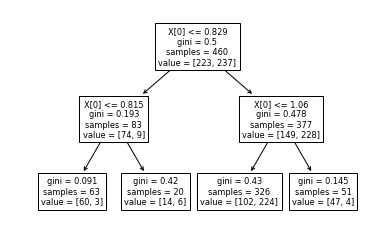

In [127]:
#train classification tree with t
x_train_t=train['t'].to_numpy()
x_test_t=test['t'].to_numpy()

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(x_train_t.reshape(-1,1),labels_train)
labels_pred=clf.predict(x_test_t.reshape(-1,1))
tree.plot_tree(clf)
print('Classification tree accuracy (for t) on the train set: %f.' % clf.score(x_train_t.reshape(-1,1),labels_train))
print('Classification tree accuracy (for t) on the test set: %f.' % metrics.accuracy_score(labels_test, labels_pred))

In [128]:
threshold_t=[clf1.tree_.threshold[0],clf1.tree_.threshold[4]]
print('%f < t < %f indicates stable perovskites.' % (threshold_t[0],threshold_t[1]) )

0.828948 < t < 1.059747 indicates stable perovskites.


Platt-scaled classification probabilities $P(t_{sisso})$ are also computed based on the $t_{sisso}$ values and the labels. Such scaled probabilities indicate the likelyhoold that a material is stable in the perovskite structure (as opposed to the stable/non-stable classification provided by the threshold alone).

In [130]:
#evaluation of P(t_sisso)
clf = CalibratedClassifierCV(cv=3)
clf.fit(x_train_t_sisso.reshape(-1,1), labels_train)
p_t_sisso_train=clf.predict_proba(x_train_t_sisso.reshape(-1,1))[:,1]
p_t_sisso_test=clf.predict_proba(x_test_t_sisso.reshape(-1,1))[:,1]
train['p_t_sisso'] = p_t_sisso_train
test['p_t_sisso'] = p_t_sisso_test

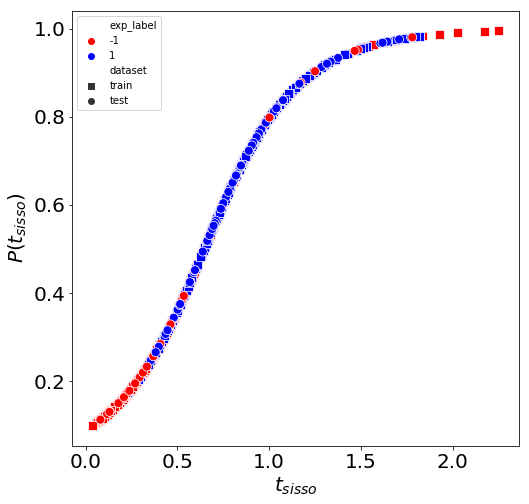

In [146]:
#plotting P(t_sisso) vs t_sisso
plt.figure(figsize=(8,8))
concat=pd.concat([train.assign(dataset='train'), test.assign(dataset='test')])
plot1=sns.scatterplot(x='t_sisso', y='p_t_sisso', data=concat,hue='exp_label', style='dataset',
               palette=['red','blue'], markers=['s','o'], s=80)
plot1.set_xlabel("$t_{sisso}$", fontsize=20)
plot1.set_ylabel("$P(t_{sisso})$", fontsize=20)
plot1.tick_params(labelsize=20)

Finally, the performance of $t_{sisso}$ and $t$ can be compared by plotting $t_{sisso}$ vs. $t$ and $P(t_{sisso})$ vs. $t$. In thes plot, each datapoint is colored according to the (true) experimental label (e.g. whether a materials is a perovskite (blue) or not (red)) for both train and test sets. 

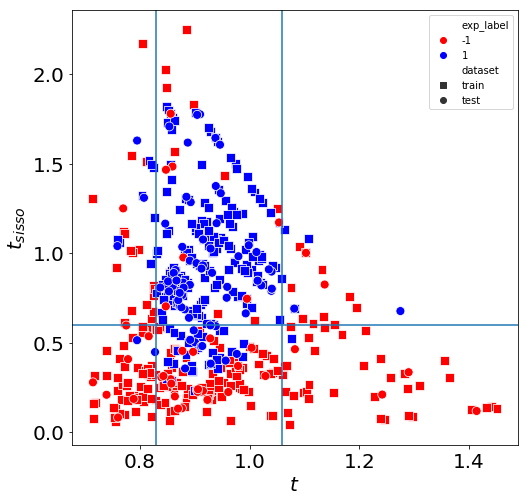

In [132]:
plt.figure(figsize=(8,8))
plot2=sns.scatterplot(x='t', y='t_sisso', data=concat, hue='exp_label', style='dataset', 
                     palette=['red','blue'], markers=['s','o'], s=80)
plot2.set_xlabel("$t$", fontsize=20)
plot2.set_ylabel("$t_{sisso}$", fontsize=20)
plot2.tick_params(labelsize=20)
plt.axvline(threshold_t[0])
plt.axvline(threshold_t[1])
plt.axhline(threshold_t_sisso)

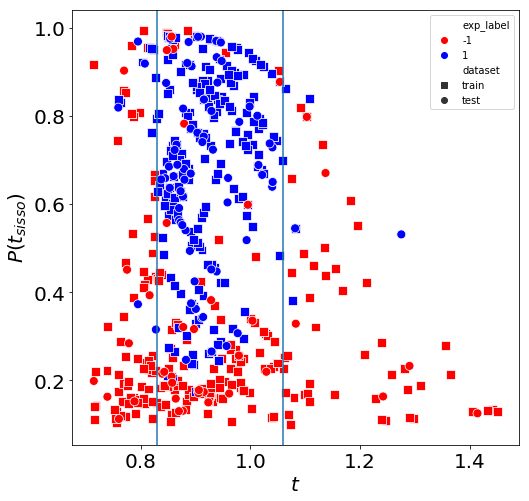

In [133]:
plt.figure(figsize=(8,8))
plot3=sns.scatterplot(x='t', y='p_t_sisso', data=concat, hue='exp_label', style='dataset', 
                     palette=['red','blue'], markers=['s','o'], s=80)
plot3.set_xlabel("$t$", fontsize=20)
plot3.set_ylabel("$P(t_{sisso})$", fontsize=20)
plot3.tick_params(labelsize=20)
plt.axvline(threshold_t[0])
plt.axvline(threshold_t[1])

# Predict stability of unseen materials (exploitation) using $t_{sisso}$

With $t_{sisso}$ in hand, one can explore large composition spaces in search for (new) compositions which are likely to form perovskites. We start by creating a list of candidate materials to be tested. 

In [134]:
potential_A=['Li','Na','K','Rb','Cs','Be','Mg','Ca','Sr','Ba','Sc','Y','La','Ce','Pr','Nd','Pm','Sm']
potential_B=['Al','Ti', 'V', 'Cr','Mn','Fe','Co','Ni','Cu', 'Zn','Ga','Ge','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','Sn','Sb','Ta','W','Pt','Pb','Bi']
potential_X=['O3']
candidates=list(map("".join, itertools.product(potential_A, potential_B, potential_X)))
print('A list of %i candidate compositions was created.' %len(candidates))

A list of 504 candidate compositions was created.


For each of the compositions, one has to predict which cations are at the $A$ and $B$-sites of the perovskite structure (based on their relative sizes) and assign oxidation states for each cation (based on their periodic table group and common oxidation states). Oxidation states are not only needed for the evaluation of the tolerance factors, but also for the determination of ionic radii, which are themselves oxidation-state dependant. Furthermore, based on oxidations states, one can assess if a given composition is charge-balanced or not. In order to perform these tasks, we use PredictABX3.py, provided as SI of Sci. Adv. 5, eaav0693 (2019). From the list of given compositions, we determine A and B and exclude the compounds that cannot be charge-balanced. 

In [139]:
for i in candidates:
    abx=PredictABX3(i)
    if isinstance(abx.pred_A,float):
        candidates.remove(i)
#    else:
#        print('For the compound %s, A = %s and B = %s' % (i, abx.pred_A, abx.pred_B))
        
print('A list of %i charge-balanced compositions was selected for further analysis:' %len(candidates))
#print(candidates)

A list of 335 charge-balanced compositions was selected for further analysis:


We then collect all the input features for each of the given materials (including the DFT-calculated atomic feature) and evalute $t_{sisso}$, $t$ and $\tau$ for each of the materials. 

In [140]:
def get_calc_feat(element):
    calc_feat=[]
    with open('atomic_features.csv') as f:
        for line in f:
            line = line.split(',')
            if line[2] == element:
                # rS (Angsrom)
                calc_feat.append(float(line[12])*1E10)
                # rP (Angstrom)
                calc_feat.append(float(line[14])*1E10)
                # Z_A 
                calc_feat.append(float(line[1]))
                # HOMO (eV)
                calc_feat.append(float(line[5])*6.241509074461E18)
                # LUMO (eV)
                calc_feat.append(float(line[6])*6.241509074461E18)
                # EA (eV)
                calc_feat.append(float(line[8])*6.241509074461E18)
                # IP (eV)
                calc_feat.append(float(line[9])*6.241509074461E18)
    return calc_feat

features=[]
for i in candidates:
    abx=PredictABX3(i)
    features.append([i, 0, abx.rA, abx.rB, abx.rX, abx.nA, abx.nB, abx.nX, abx.rA/abx.rB, abx.rA/abx.rX, abx.rB/abx.rX, *get_calc_feat(abx.pred_A), *get_calc_feat(abx.pred_B), *get_calc_feat(abx.X)])

exploit=pd.DataFrame(features, columns=['material', 'tau_pred_label',
                                        'rA','rB','rX','nA','nB','nX','rA_rB_ratio','rA_rX_ratio','rB_rX_ratio',
                                        'rS_A','rP_A','Z_A','HOMO_A','LUMO_A','EA_A','IP_A',
                                        'rS_B','rP_B','Z_B','HOMO_B','LUMO_B','EA_B','IP_B',
                                        'rS_X','rP_X','Z_X','HOMO_X','LUMO_X','EA_X','IP_X'])

exploit.eval('t_sisso = ' + t_sisso_expression, inplace=True)
exploit.eval('tau = rX/rB-nA*(nA-rA_rB_ratio/log(rA_rB_ratio))', inplace=True)
exploit.eval('t = (rA+rX)/(1.41421*(rB+rX))', inplace=True)
exploit

material  tau_pred_label    rA     rB   rX  nA  nB  nX  rA_rB_ratio  \
0      LiVO3               0  0.92  0.540  1.4   1   5  -2     1.703704   
1     LiCrO3               0  0.92  0.490  1.4   1   5  -2     1.877551   
2     LiMnO3               0  0.92  0.330  1.4   1   5  -2     2.787879   
3     LiNbO3               0  0.92  0.640  1.4   1   5  -2     1.437500   
4     LiMoO3               0  0.92  0.610  1.4   1   5  -2     1.508197   
..       ...             ...   ...    ...  ...  ..  ..  ..          ...   
330   SmTaO3               0  1.24  0.720  1.4   3   3  -2     1.722222   
331    SmWO3               0  1.32  0.660  1.4   2   4  -2     2.000000   
332   SmPtO3               0  1.32  0.625  1.4   2   4  -2     2.112000   
333   SmPbO3               0  1.32  0.775  1.4   2   4  -2     1.703226   
334   SmBiO3               0  1.17  0.958  1.4   3   3  -2     1.221294   

     rA_rX_ratio  ...    rS_X    rP_X  Z_X    HOMO_X    LUMO_X      EA_X  \
0       0.657143  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
1       0.657143  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
2       0.657143  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
3       0.657143  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
4       0.657143  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
..           ...  ...     ...     ...  ...       ...       ...       ...   
330     0.885714  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
331     0.942857  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
332     0.942857  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
333     0.942857  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   
334     0.835714  ...  0.4608  0.4333  8.0 -9.030485 -0.068724 -3.078804   

          IP_X   t_sisso        tau         t  
0    16.431366  0.166566   4.790207  0.845614  
1    16.431366  0.151143   4.837533  0.867985  
2    16.431366  0.101790   5.961561  0.948261  
3    16.431366  0.197411   5.148586  0.804163  
4    16.431366  0.188157   4.965422  0.816165  
..         ...       ...        ...       ...  
330  16.431366  1.210356   2.448712  0.880550  
331  16.431366  0.838181   3.891992  0.933658  
332  16.431366  0.793732   3.889813  0.949795  
333  16.431366  0.984227   4.203256  0.884292  
334  16.431366  1.433753  10.788926  0.770682  

[335 rows x 35 columns]

In [141]:
x_exploit_t_sisso=exploit['t_sisso'].to_numpy()
p_t_sisso_exploit=clf2.predict_proba(x_exploit_t_sisso.reshape(-1,1))[:,1]
exploit['p_t_sisso'] = p_t_sisso_exploit

By using the established threshold, one can now determine which are the materials predicted to be stable at the perovskite structure using the tolerance factor identified by SISSO.

In [145]:
stable_candidates_t_sisso=[]
for i in list(range(len(exploit))):
    if exploit['t_sisso'][i] < threshold_t_sisso:
        stable_candidates_t_sisso.append(exploit['material'][i])

print('According to t_sisso, %i compositions are predicted to be stable as perovskites:' %len(stable_candidates_t_sisso))
print(stable_candidates_t_sisso)

According to t_sisso, 96 compositions are predicted to be stable as perovskites:
['LiVO3', 'LiCrO3', 'LiMnO3', 'LiNbO3', 'LiMoO3', 'LiTcO3', 'LiRuO3', 'LiRhO3', 'LiSbO3', 'LiTaO3', 'LiWO3', 'LiPtO3', 'LiBiO3', 'NaVO3', 'NaCrO3', 'NaMnO3', 'NaNbO3', 'NaMoO3', 'NaTcO3', 'NaRuO3', 'NaRhO3', 'NaSbO3', 'NaTaO3', 'NaWO3', 'NaPtO3', 'NaBiO3', 'KVO3', 'KCrO3', 'KMnO3', 'KMoO3', 'KTcO3', 'KRuO3', 'KRhO3', 'KSbO3', 'KPtO3', 'RbVO3', 'RbCrO3', 'RbMnO3', 'RbRhO3', 'CsMnO3', 'BeTiO3', 'BeVO3', 'BeCrO3', 'BeMnO3', 'BeFeO3', 'BeCoO3', 'BeNiO3', 'BeGeO3', 'BeZrO3', 'BeNbO3', 'BeMoO3', 'BeTcO3', 'BeRuO3', 'BeRhO3', 'BePdO3', 'BeSnO3', 'BeTaO3', 'BeWO3', 'BePtO3', 'BePbO3', 'MgTiO3', 'MgVO3', 'MgCrO3', 'MgMnO3', 'MgFeO3', 'MgCoO3', 'MgNiO3', 'MgGeO3', 'MgZrO3', 'MgNbO3', 'MgMoO3', 'MgTcO3', 'MgRuO3', 'MgRhO3', 'MgPdO3', 'MgSnO3', 'MgTaO3', 'MgWO3', 'MgPtO3', 'ScAlO3', 'ScTiO3', 'ScVO3', 'ScCrO3', 'ScMnO3', 'ScFeO3', 'ScCoO3', 'ScNiO3', 'ScCuO3', 'ScGaO3', 'ScNbO3', 'ScMoO3', 'ScRuO3', 'ScRhO3', 'ScPdO3'

We can also compare the results obtained with of $t_{sisso}$ with $t$ and $\tau$. In the $P(t_{sisso})$ vs. $t$ plot below, the datapoints are colored acording to their stability predicted by $\tau$.

In [143]:
for i in list(range(len(exploit))):
    if exploit['tau'][i] < 4.18:
        exploit['tau_pred_label'][i]=1
    else:
        exploit['tau_pred_label'][i]=-1

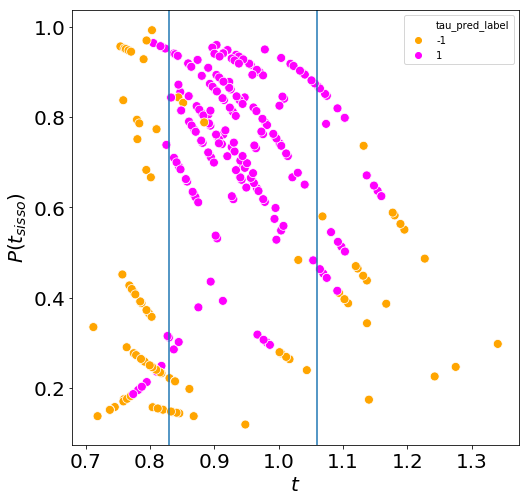

In [144]:
#plot
plt.figure(figsize=(8,8))
plot2=sns.scatterplot(x='t', y='p_t_sisso', data=exploit, hue='tau_pred_label', 
                     palette=['orange','magenta'], markers=['s'], s=80)
plot2.set_xlabel("$t$", fontsize=20)
plot2.set_ylabel("$P(t_{sisso})$", fontsize=20)
plot2.tick_params(labelsize=20)
plt.axvline(threshold_t[0])
plt.axvline(threshold_t[1])